In [11]:
# Incident Detection + Bus ETA System

!pip install ultralytics osmnx folium streamlit_folium geopy flask-ngrok pyngrok

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import os
from geopy.distance import geodesic
from math import radians, sin, cos, asin, sqrt
print("Environment ready.")

Environment ready.


In [3]:
# Download Enugu Bus Stops from OpenStreetMap

import osmnx as ox
place = "Enugu, Nigeria"
bus_stops = ox.features.features_from_place(place, tags={"highway": "bus_stop"})
bus_stops[["name","geometry"]].to_csv("enugu_bus_stops.csv", index=False)
bus_stops.head()

geometry  bus   highway  \
element id                                                   
node    5768474619  POINT (7.50765 6.42506)  yes  bus_stop   
        8752872914  POINT (7.51055 6.46147)  yes  bus_stop   
        8753562890   POINT (7.5108 6.43966)  yes  bus_stop   
        8753562911   POINT (7.5312 6.41706)  yes  bus_stop   
        8753583046  POINT (7.49404 6.47829)  yes  bus_stop   

                                      name public_transport bench shelter  
element id                                                                 
node    5768474619           MANUAH BUSTOP         platform   yes     yes  
        8752872914  Ogui Junction Bus-Stop         platform   NaN     NaN  
        8753562890       Mkpokiti Bus Stop         platform   NaN     NaN  
        8753562911       Oshimiri bus stop         platform   NaN     NaN  
        8753583046             Trans-Ekulu         platform   NaN     NaN

In [4]:
# Incident Detection (YOLOv8) Setup

from ultralytics import YOLO
model = YOLO('yolov8n.pt') # tiny model for speed
test_video = "https://github.com/ultralytics/assets/releases/download/v0.0.0/bus.mp4"


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Incident Detection (YOLOv8) Setup

from ultralytics import YOLO
model = YOLO('yolov8n.pt') # tiny model for speed
test_video = "https://www.learningcontainer.com/wp-content/uploads/2020/05/sample-mp4-file.mp4"
!wget -O sample.mp4 $test_video

--2025-11-21 03:20:21--  https://www.learningcontainer.com/wp-content/uploads/2020/05/sample-mp4-file.mp4
Resolving www.learningcontainer.com (www.learningcontainer.com)... 172.67.188.164, 104.21.84.74, 2606:4700:3033::ac43:bca4, ...
Connecting to www.learningcontainer.com (www.learningcontainer.com)|172.67.188.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546620 (10M) [video/mp4]
Saving to: ‘sample.mp4’

sample.mp4          100%[===================>]  10.06M  --.-KB/s    in 0.1s    

2025-11-21 03:20:21 (91.9 MB/s) - ‘sample.mp4’ saved [10546620/10546620]



In [6]:
# Run YOLO Inference on Sample Video

results = model.predict(source="sample.mp4", save=True)
results


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1889) /content/sample.mp4: 480x640 1 cow, 380.6ms
video 1/1 (frame 2/1889) /content/sample.mp4: 480x640 1 cow, 163.5ms
video 1/1 (frame 3/1889) /content/sample.mp4: 480x640 1 dog, 185.3ms
video 1/1 (frame 4/1889) /content/sample.mp4: 480x640 1 cat, 1 dog, 164.3ms
video 1/1 (frame 5/1889) /content/sample.mp4: 480x640 1 sheep, 166.5ms
video 1/1 (frame 6/1889) /content/sample.mp4: 480x640 2 sheeps, 174.3ms
video 1/1 (frame 7/1889) /cont

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [7]:
# Build Simple Incident Dataset CSV

import csv

# Create simple incident dataset CSV
with open("sample_incident_data_enugu.csv", "w", newline="") as f:
    writer = csv.writer(f)

    # Write header
    writer.writerow(["timestamp", "location", "incident_type", "vehicle_count"])

    # Write sample rows
    writer.writerow(["2025-01-10 08:30:00", "New Haven, Enugu", "stalled_vehicle", 12])
    writer.writerow(["2025-01-10 09:15:00", "Ogbete Market Road", "heavy_traffic", 25])
    writer.writerow(["2025-01-10 09:45:00", "Otigba Junction", "minor_collision", 8])
    writer.writerow(["2025-01-10 10:10:00", "Independence Layout", "congestion", 30])

print("CSV created successfully!")


CSV created successfully!


In [8]:
# Build Bus ETA Predictor

 # --- Paste this entire cell into Colab and run it ---

import math
import pandas as pd

def haversine(lon1, lat1, lon2, lat2):
    """Return distance in kilometers between two points using haversine formula."""
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Example Enugu bus stops (lat, lon)
bus_stops = pd.DataFrame({
    "stop_name": ["New Haven Junction", "Ogbete Market", "Mayor Bus Stop", "IMT Campus 2"],
    "lat": [6.4400, 6.4501, 6.4653, 6.4580],
    "lon": [7.4948, 7.4989, 7.5080, 7.5182]
})

# Compute distance between consecutive stops (km) and estimated travel time (min)
distances_km = []
for i in range(len(bus_stops) - 1):
    lat1, lon1 = bus_stops.loc[i, ["lat", "lon"]]
    lat2, lon2 = bus_stops.loc[i + 1, ["lat", "lon"]]
    dist = haversine(lon1, lat1, lon2, lat2)
    distances_km.append(dist)

# last stop has no 'next' stop
distances_km.append(0.0)
bus_stops["distance_to_next_km"] = distances_km

# assume average speed (adjustable)
average_speed_kmh = 25.0
bus_stops["travel_time_min"] = (bus_stops["distance_to_next_km"] / average_speed_kmh) * 60.0

bus_stops



,stop_name,lat,lon,distance_to_next_km,travel_time_min
0,New Haven Junction,6.4400,7.4948,1.210995,2.906388
1,Ogbete Market,6.4501,7.4989,1.966618,4.719884
2,Mayor Bus Stop,6.4653,7.5080,1.388879,3.333310
3,IMT Campus 2,6.4580,7.5182,0.000000,0.000000


Found existing installation: pystan 3.10.0
Uninstalling pystan-3.10.0:
  Successfully uninstalled pystan-3.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 70.3 MB/s eta 0:00:00


,ds,y
0,2024-11-01,7
1,2024-11-02,8
2,2024-11-03,6
3,2024-11-04,8
4,2024-11-05,8


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


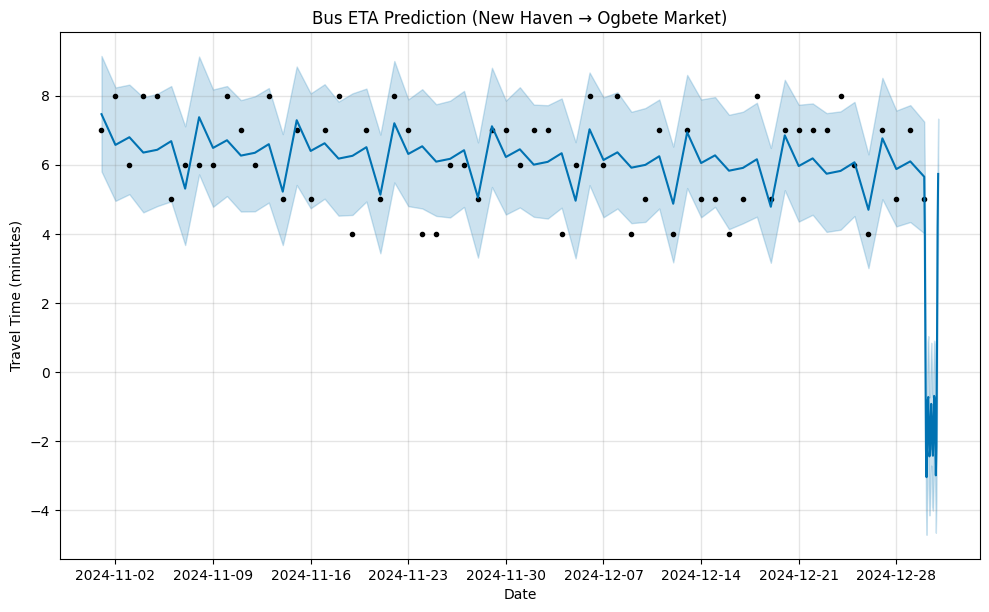

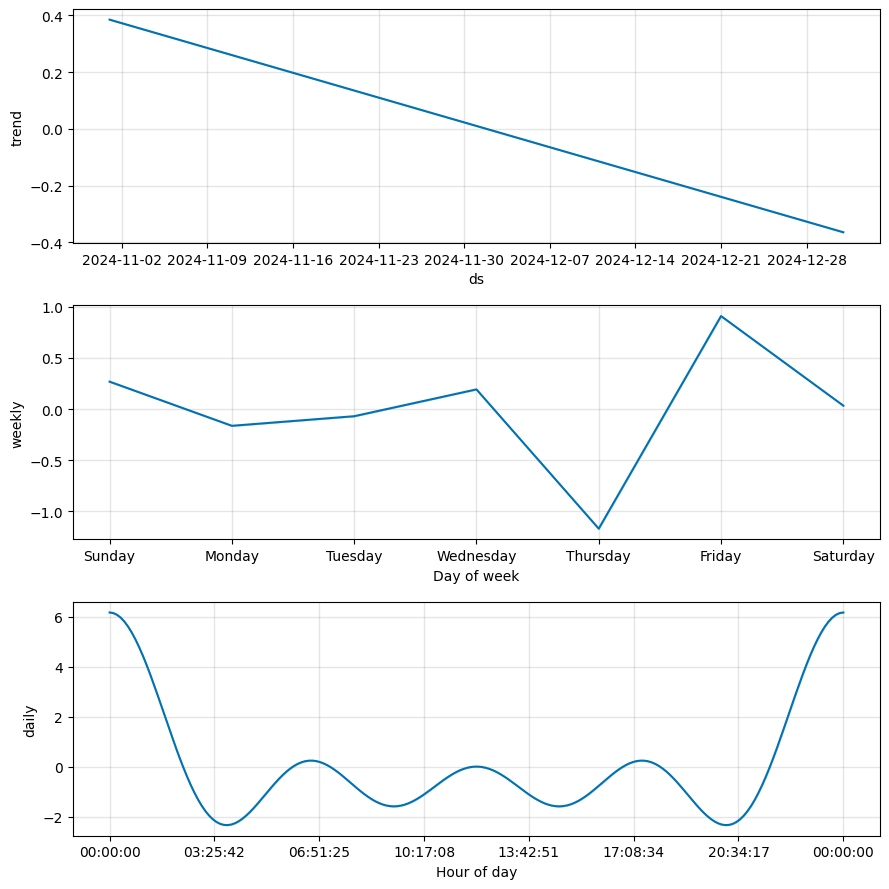

,83
ds,2024-12-31 00:00:00
yhat,5.731591
yhat_lower,4.05574
yhat_upper,7.332133


In [12]:
# --- PROPHET ETA PREDICTOR FOR ENUGU BUS ROUTES ---

!pip uninstall prophet -y
!pip uninstall pystan -y
!pip install pystan --quiet
!pip install prophet --quiet

import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# -------------------------------
# 1. Create Synthetic Bus Travel-Time Dataset
# -------------------------------

# Simulate 60 days of historical travel time between:
# New Haven → Ogbete Market → Mayor Bus Stop → IMT Campus 2
# Focus: segment 1 (New Haven → Ogbete), we can extend later

np.random.seed(42)

days = pd.date_range(start="2024-11-01", periods=60, freq="D")
base_travel_time = 6  # base travel mins (light traffic)

# Add realistic Enugu traffic variations:
# Morning peak: +4 min
# Evening peak: +3 min
# Random jitter: 2 min

travel_times = []
for d in days:
    t = base_travel_time

    # morning rush (7–9 AM)
    if 7 <= d.hour <= 9:
        t += 4

    # evening slows down (4–6 PM)
    if 16 <= d.hour <= 18:
        t += 3

    # daily noise
    t += np.random.randint(-2, 3)

    travel_times.append(t)

df = pd.DataFrame({
    "ds": days,
    "y": travel_times
})

display(df.head())

# -------------------------------
# 2. Train Prophet Model
# -------------------------------

model = Prophet(
    interval_width=0.85,
    daily_seasonality=True,
    weekly_seasonality=True
)
model.fit(df)

# -------------------------------
# 3. Forecast next 24 hours travel time
# -------------------------------

future = model.make_future_dataframe(periods=24, freq="H")
forecast = model.predict(future)

# -------------------------------
# 4. Visualize forecast
# -------------------------------

fig1 = model.plot(forecast)
plt.title("Bus ETA Prediction (New Haven → Ogbete Market)")
plt.xlabel("Date")
plt.ylabel("Travel Time (minutes)")
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

# -------------------------------
# 5. Extract next ETA prediction
# -------------------------------

next_prediction = forecast.iloc[-1][["ds", "yhat", "yhat_lower", "yhat_upper"]]
next_prediction

In [13]:
print("Notebook execution complete.")

Notebook execution complete.


In [23]:
%%writefile ingest.py
import sqlite3
import datetime
from flask import Flask, request, jsonify
import os

app = Flask(__name__)

# Choose DB type
USE_SQLITE = True   # set False if using Postgres

if USE_SQLITE:
    DB = "smartcity.db"
    conn = sqlite3.connect(DB, check_same_thread=False)
else:
    import psycopg2
    conn = psycopg2.connect(
        dbname=os.environ.get("POSTGRES_DB", "smartcity"),
        user=os.environ.get("POSTGRES_USER", "postgres"),
        password=os.environ.get("POSTGRES_PASSWORD", "postgres"),
        host=os.environ.get("POSTGRES_HOST", "localhost"),
        port=5432
    )

cur = conn.cursor()

# Create table if not exists
cur.execute("""
CREATE TABLE IF NOT EXISTS vehicle_pings (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    vehicle_id TEXT,
    lat REAL,
    lon REAL,
    ts TEXT
)
""")
conn.commit()


@app.route("/ping", methods=["POST"])
def ingest_ping():
    data = request.json

    vehicle_id = data.get("vehicle_id")
    lat = data.get("lat")
    lon = data.get("lon")
    ts = data.get("ts", datetime.datetime.utcnow().isoformat())

    if not vehicle_id or lat is None or lon is None:
        return jsonify({"error": "Missing fields"}), 400

    cur.execute(
        "INSERT INTO vehicle_pings (vehicle_id, lat, lon, ts) VALUES (?, ?, ?, ?)",
        (vehicle_id, lat, lon, ts)
    )
    conn.commit()

    return jsonify({"status": "ok"}), 200


@app.route("/latest", methods=["GET"])
def get_latest():
    cur.execute("SELECT vehicle_id, lat, lon, ts FROM vehicle_pings ORDER BY id DESC LIMIT 50")
    rows = cur.fetchall()

    return jsonify([
        {"vehicle_id": r[0], "lat": r[1], "lon": r[2], "ts": r[3]}
        for r in rows
    ])


if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5001)


Writing ingest.py


In [15]:
!pip install waitress pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 2.1 MB/s eta 0:00:00


In [24]:
%%writefile wsgi.py

from ingest import app
from waitress import serve

if __name__ == "__main__":
    serve(app, host="0.0.0.0", port=5001)


Overwriting wsgi.py


In [33]:
from pyngrok import ngrok

# Get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
ngrok.set_auth_token("35m5GJUasSYxEuqbjURsLxCMBMg_27nrXTLe6FvkRVP1c3Gof")

public_url = ngrok.connect(addr=5001, hostname="virgilio-epiphenomenal-halina.ngrok-free.dev")
public_url

<NgrokTunnel: "https://virgilio-epiphenomenal-halina.ngrok-free.dev" -> "http://localhost:5001">

In [34]:
!python wsgi.py


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/waitress/server.py", line 325, in run
    self.asyncore.loop(
  File "/usr/local/lib/python3.12/dist-packages/waitress/wasyncore.py", line 240, in loop
    poll_fun(timeout, map)
  File "/usr/local/lib/python3.12/dist-packages/waitress/wasyncore.py", line 167, in poll
    r, w, e = select.select(r, w, e, timeout)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/wsgi.py", line 6, in <module>
    serve(app, host="0.0.0.0", port=5001)
  File "/usr/local/lib/python3.12/dist-packages/waitress/__init__.py", line 19, in serve
    server.run()
  File "/usr/local/lib/python3.12/dist-packages/waitress/server.py", line 331, in run
    self.task_dispatcher.shutdown()
  File "/usr/local/lib/python3.12/dist-packages/waitress/task.py", line 118, in shutdown
    self.set_thread_count(0

In [40]:
%%writefile gps_simulator.py
import time
import requests
import random

url = "https://virgilio-epiphenomenal-halina.ngrok-free.dev" # ingest API endpoint

# Simulated bus route: New Haven → Ogbete → Mayor → IMT Campus 2
route = [
    (6.4400, 7.4948),
    (6.4501, 7.4989),
    (6.4653, 7.5080),
    (6.4580, 7.5182),
]

while True:
    for lat, lon in route:
        # Add tiny random noise to mimic GPS drift
        lat += random.uniform(-0.0005, 0.0005)
        lon += random.uniform(-0.0005, 0.0005)

        r = requests.post(url, json={
            "vehicle_id": "bus1",
            "lat": lat,
            "lon": lon
        })

        print("Sent GPS ping:", lat, lon, "| Status:", r.status_code)
        time.sleep(3)  # wait 3 seconds before next ping


Writing gps_simulator.py


In [43]:
%%writefile streamlit_app.py
from math import radians, sin, cos, atan2, sqrt

def haversine(lat1, lon1, lat2, lon2):
    # Convert to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    r = 6371  # Earth radius in km
    return r * c


Writing streamlit_app.py


In [1]:
%%writefile run_onnx.py
import cv2
import time

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Cannot open camera")
    exit()

while True:
    ret, frame = cap.read()   # <-- MUST be indented under while

    if not ret:
        print("Failed to grab frame")
        break

    cv2.imshow("Smart City – Camera Feed", frame)

    # Press Q to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()



Writing run_onnx.py
